In [1]:
%matplotlib inline
%reset -f 
import FS3
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import scipy as sp
import scipy.optimize

mpl.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': 'cmr10',
    'mathtext.fontset': 'cm',
    'font.family': 'STIXGeneral',
    'axes.unicode_minus': True,
    'axes.labelsize' : 21,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 16,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.top': 'on',
    'xtick.major.bottom': 'on',
    'ytick.major.left': 'on',
    'ytick.major.right': 'on',
    'xtick.top': True,
    'ytick.right': True })

File format:
<pre>
#0
5     6.50     0.32276249    0.00063628    
5     7.50     0.40757436    0.00054231    
5     8.50     0.50600748    0.00017793    


#1
7     6.50     0.26643471    0.00064648    
7     7.50     0.36700643    0.00072537    
7     8.50     0.50036142    0.00067841    
</pre>

In [2]:
sigma = 'sm05'; Trange = np.array([2.37,2.47]); g0 = 2.43; nu0 = 1.00
sigma = '_s00'; Trange = np.array([1.335, 1.346]); g0 = 1.342; nu0 = 1.00
sigma = '_s05'; Trange = np.array([0.9, 0.93]); g0 = 0.92; nu0 = 1.1
#sigma = '_s10'; Trange = np.array([0.62, 0.68]); g0 = 0.63; nu0 = 1.33
#sigma = '_s15'; Trange = np.array([0.48, 0.54]); g0 = 0.5; nu0 = 1.75

#sigma ="_SR"; Trange=[1.25,1.27]; g0 = 1.26

# $\nu$

<AxesSubplot:xlabel='$T$', ylabel='$U_2$'>

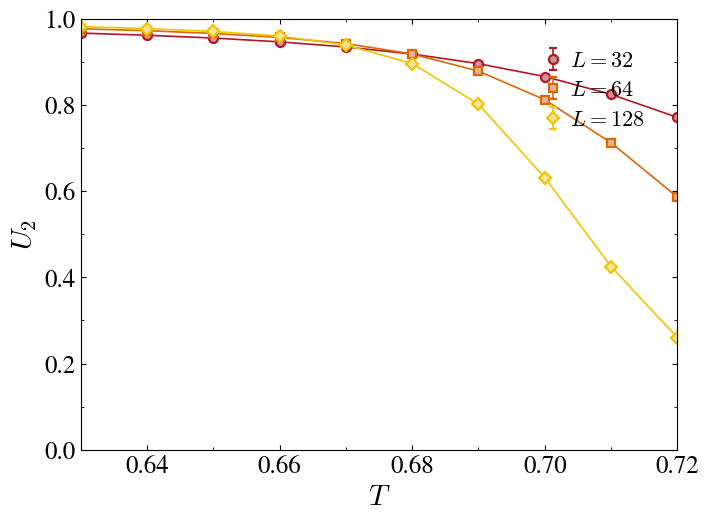

In [68]:
data = FS3.load('../../dataT/BinderLEO%s.dat'%(sigma), LIndex=0, xIndex=1, yIndex=2, dyIndex=3)
FS3.setStyle(Llist=np.sort(list(data),axis=0))

fig, ax0 = FS3.figure(xlabel=r'$T$', ylabel=r'$U_2$')
xrange = FS3.getDataRange(data, idx=0, margin=0.05)
ax0.set_xlim(data[128][0,0],data[128][-1,0])
ax0.set_ylim(0,1)
FS3.setTicks(ax0, minorxTicks=2, minoryTicks=2)
plots = []
labels = []
for L in np.sort(list(data),axis=0):
    p = ax0.errorbar(data[L][:,0], data[L][:,1], yerr=data[L][:,2], **FS3.errorbarStyle(L), linestyle='')
    ax0.plot(data[L][:,0], data[L][:,1], **FS3.plotStyle(L), linestyle='-')
    plots.append(p)
    labels.append(r'$L = %s$'%L)
FS3.legend(ax0, plots, labels, legendLabelBreak=7, loc=(0.74,0.72,0.18))
#fig.savefig("Binder_sm05.pdf")


In [2]:
class f0:
    def __init__(self):
        self.vars = ['gc', 'nu','omega','c']   # define the variables used in your scaling function
        self.polyOrder = 0         # the polyomial expansion order in your scaling function

    def nparams(self):
        return len(self.vars) + np.sum(self.polyOrder) + 1
    
    def unpack(self, params):
        var = {}
        for name in list(self.vars):
            var[name] = params[self.vars.index(name)]
        var['a']  = params[len(self.vars):self.nparams() + 1]
        return var

    def func(self, g, L, params):
        var = self.unpack(params)
        nmax = len(var['a'])

        f = np.zeros_like(g)
        for n in range(nmax):
            f += var['a'][n] * ((g-var['gc']) * L**(1./var['nu'])+var['c'])**n
        return f

In [52]:
data = FS3.load('../dataJ/Binder_SR.dat', LIndex=0, xIndex=1, yIndex=2, dyIndex=3)
data = FS3.select(data, gRange=[1.25,1.27])
FS3.setStyle(Llist=np.sort(list(data),axis=0))

fitFunction = f0()
fitFunction.polyOrder = 4

params0 = np.hstack(([g0+np.random.randn()*0.01, nu0+np.random.randn()*0.01], 0.01*np.random.randn(fitFunction.nparams()-2)))
res = FS3.fit_minimize(data, fitFunction, params=params0, **{'method': 'BFGS'})
params, dparams, redChi2, mesg, ierr = res

FS3.fitSummary(fitFunction, res)

chi2/d.o.f = 5.38          
gc = 1.26094(3)
nu = 0.749(4)
omega = 0(1)
c = -0.987(3)
a[0] = 0.499(3)
a[1] = -0.117(4)
a[2] = -0.0046(2)
a[3] = 0.0018(2)
a[4] = 0.00017(2)



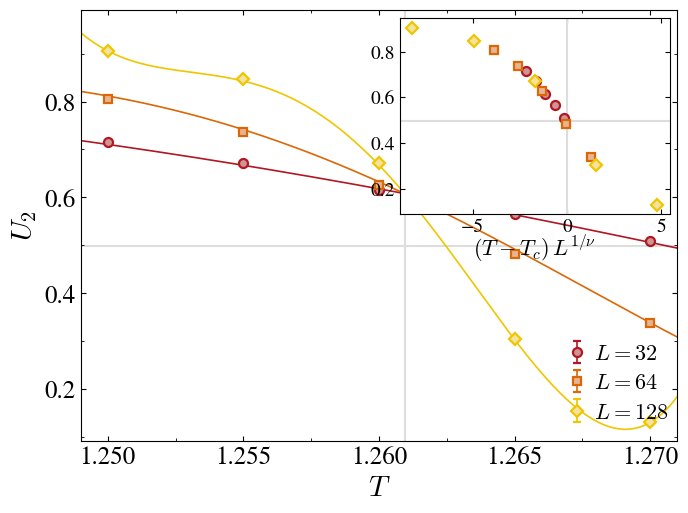

In [53]:
# main panel, crossings
var = fitFunction.unpack(params)
fig, ax0 = FS3.figure(xlabel=r'$T$', ylabel=r'$U_2$')
xrange, yrange = FS3.getDataRange(data, idx=0, margin=0.05), FS3.getDataRange(data, idx=1, margin=0.05)
yrange[1] = 1.05*yrange[1]
ax0.set_xlim(xrange)
ax0.set_ylim(yrange)
FS3.setTicks(ax0, minorxTicks=2, minoryTicks=2)
plots = []
labels = []
for L in np.sort(list(data),axis=0):
    p = ax0.errorbar(data[L][:,0], data[L][:,1], yerr=data[L][:,2], **FS3.errorbarStyle(L), linestyle='')
    plots.append(p)
    labels.append(r'$L = %s$'%L)
    plotRange = FS3.getDataRange(data[L], idx=0, margin=0.05)
    g = np.linspace(plotRange[0], plotRange[1], 400)
    ax0.plot(g, fitFunction.func(g, L, params), **FS3.plotStyle(L))
FS3.legend(ax0, plots, labels, legendLabelBreak=7, loc=(0.78,0.02,0.18))
ax0.axhline(var['a'][0], color='#dddddd', zorder=-1000)
ax0.axvline(var['gc'], color='#dddddd', zorder=-1000)

# inset (data collapse)

fig, ax1 = FS3.addInset(fig, loc=3)
ax1.set_xlabel(r'$(T-T_c)\, L^{1/\nu}$')
dataCollapse = FS3.rescaleAxis(data, xfunc='(x-gc)*L**(1./nu) + c*L**(omega/nu)', yfunc='y', arg={'nu': var['nu'], 'gc': var['gc'], 'omega': var['omega'], 'c': var['c']})
for L in np.sort(list(data),axis=0):
    ax1.errorbar(dataCollapse[L][:,0], dataCollapse[L][:,1], yerr=dataCollapse[L][:,2], **FS3.errorbarStyle(L), linestyle='')
ax1.axhline(var['a'][0], color='#dddddd')
ax1.axvline(0, color='#dddddd')

#fig.savefig("Binder_sm00_zoom.pdf")

In [17]:
def resample(data):
    dataSample = {}
    for L in np.sort(list(data),axis=0):
        n = len(data[L])
        dataSample[L] = np.zeros((n,2))
        dataSample[L][:,0] = data[L][:,0]
        dataSample[L][:,1] = data[L][:,1] + np.random.randn(n) * data[L][:,2]
    return dataSample

In [18]:
data = FS3.load('../dataJ/Binder%s.dat'%(sigma), LIndex=0, xIndex=1, yIndex=2, dyIndex=3)
data = FS3.select(data, gRange=Trange)
FS3.setStyle(Llist=np.sort(list(data),axis=0))

nsample = 100
resList = np.empty((0,3))
for i in range(nsample):
    fitFunction = f0()
    fitFunction.polyOrder = 3
    
    params0 = np.hstack(([g0+np.random.randn()*0.01, nu0+np.random.randn()*0.01, 0.5 + np.random.randn()*0.01], np.random.randn(fitFunction.nparams()-3)))
    res = FS3.fit_minimize(resample(data), fitFunction, params=params0, **{'method': 'BFGS'})
    params, dparams, redChi2, mesg, ierr = res
    if np.abs(fitFunction.unpack(params)['gc']-g0) < 0.5 and np.abs(fitFunction.unpack(params)['nu']-1.0) < 1.0:
        resList = np.vstack((resList, np.array([fitFunction.unpack(params)['gc'], fitFunction.unpack(params)['nu'], redChi2])))
print('Tc = %s'%(FS3.errText(np.mean(resList[:,0]), np.std(resList[:,0]))))
print('nu = %s'%(FS3.errText(np.mean(resList[:,1]), np.std(resList[:,1]))))
print(len(resList))

/home/daniel/master_thesis/Code_Cleanup/Analysis/FS3.py:56: RuntimeWarning: overflow encountered in square
  return np.sum(res**2)
/home/daniel/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/daniel/master_thesis/Code_Cleanup/Analysis/FS3.py:56: RuntimeWarning: overflow encountered in square
  return np.sum(res**2)


Tc = 1.27(5)
nu = 0.9(2)
89


Text(0.5, 0, '$T_c$')

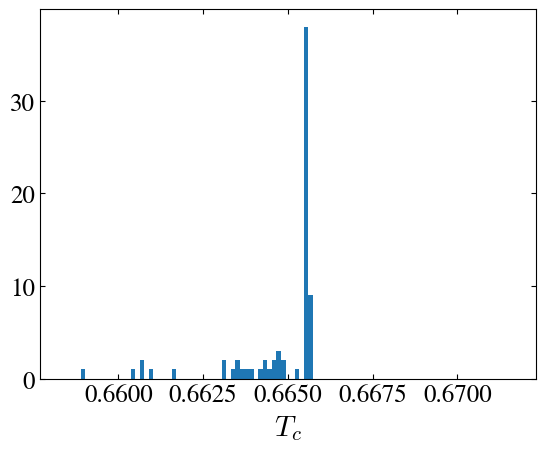

In [153]:
_ = plt.hist(resList[:,0], np.linspace(0.99*0.665,1.01*0.665,100))
plt.xlabel(r'$T_c$')

Text(0.5, 0, '$\\chi^2$')

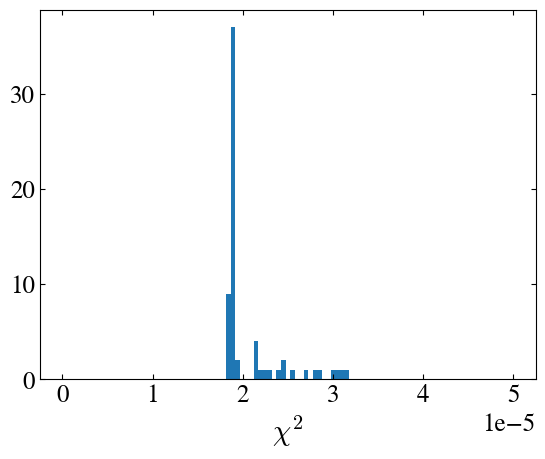

In [156]:
_ = plt.hist(resList[:,2], np.linspace(0,5e-5,100))
plt.xlabel(r'$\chi^2$')

Text(0.5, 0, '$\\nu$')

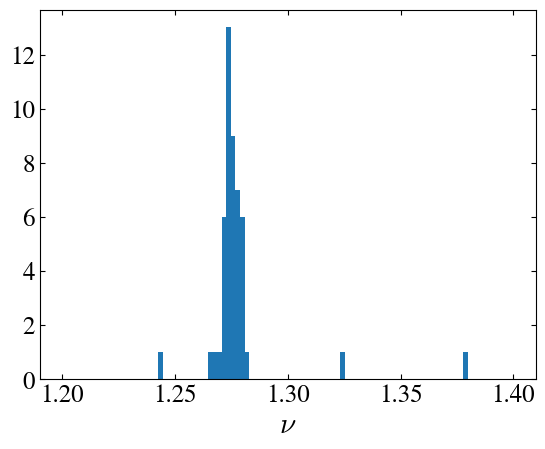

In [157]:
_ = plt.hist(resList[:,1], np.linspace(1.2,1.4,100))
plt.xlabel(r'$\nu$')

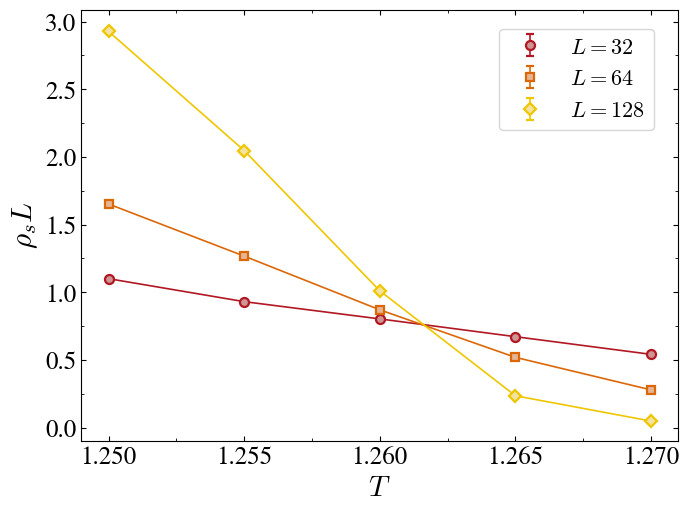

In [25]:
data = FS3.load('../dataJ/spin_stiffnessL%s.dat'%(sigma), LIndex=0, xIndex=1, yIndex=2, dyIndex=3)
Llist = np.sort(list(data),axis=0)
FS3.setStyle(Llist=Llist)
for L in Llist:
    data[L][:,1:3] /= 1

fig, ax0 = FS3.figure(xlabel=r'$T$', ylabel=r'$\rho_sL$')
#ax0.set_xlim(Trange[0],Trange[1]+0.01)
#ax0.set_ylim(0,0.2)
FS3.setTicks(ax0, minorxTicks=2, minoryTicks=2)
plots = []
labels = []
for L in np.sort(list(data),axis=0):
    ax0.errorbar(data[L][:,0], data[L][:,1], yerr=data[L][:,2], **FS3.errorbarStyle(L), linestyle='', label=r'$L = %s$'%L)
    ax0.plot(data[L][:,0], data[L][:,1], **FS3.plotStyle(L), linestyle='-')
ax0.legend(loc=(0.7,0.72))
#fig.savefig("spin_stiffness_sm05.pdf")


In [160]:
Trange = np.array([0.63,0.65])

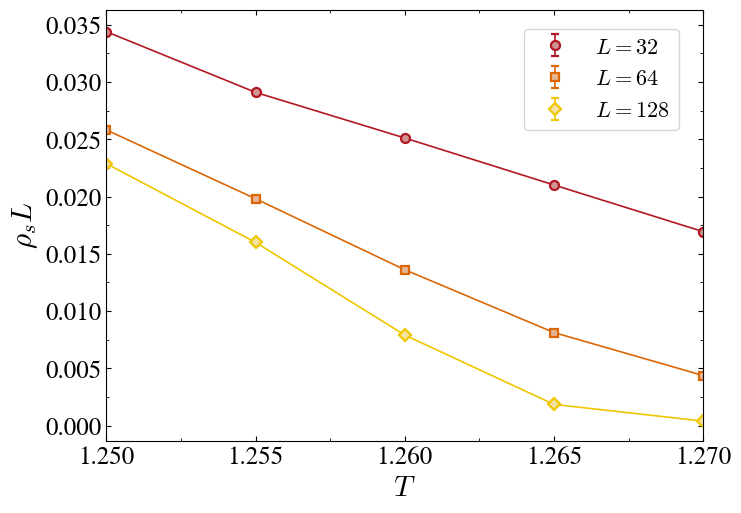

In [54]:
data = FS3.load('../dataJ/spin_stiffness%s.dat'%(sigma), LIndex=0, xIndex=1, yIndex=2, dyIndex=3)
Llist = np.sort(list(data),axis=0)
FS3.setStyle(Llist=Llist)
for L in Llist:
    data[L][:,1:3] /= 1

fig, ax0 = FS3.figure(xlabel=r'$T$', ylabel=r'$\rho_s L$')
ax0.set_xlim(Trange)
#ax0.set_ylim(0.4,0.6)
FS3.setTicks(ax0, minorxTicks=2, minoryTicks=2)
plots = []
labels = []
for L in np.sort(list(data),axis=0):
    ax0.errorbar(data[L][:,0], data[L][:,1], yerr=data[L][:,2], **FS3.errorbarStyle(L), linestyle='', label=r'$L = %s$'%L)
    ax0.plot(data[L][:,0], data[L][:,1], **FS3.plotStyle(L), linestyle='-')
ax0.legend(loc=(0.7,0.72))
#fig.savefig("spin_stiffness_s10_zoom.pdf")

In [60]:
data = FS3.load('../dataJ/spin_stiffnessL%s.dat'%(sigma), LIndex=0, xIndex=1, yIndex=2, dyIndex=3)
data = FS3.select(data, gRange=Trange)
Llist = np.sort(list(data),axis=0)
FS3.setStyle(Llist=Llist)
for L in Llist:
    data[L][:,1:3] /= 1    # data = L*rho_s

fitFunction = f0()
fitFunction.polyOrder = 3

params0 = np.hstack(([g0+np.random.randn()*0.01, nu0+np.random.randn()*0.01], np.random.randn(fitFunction.nparams()-2)))
res = FS3.fit_minimize(data, fitFunction, params=params0, **{'method': 'BFGS'})
params, dparams, redChi2, mesg, ierr = res

FS3.fitSummary(fitFunction, res)

chi2/d.o.f = 9.60          
gc = 1.26138(2)
nu = 0.739(3)
omega = 1(1)
c = -0.879(4)
a[0] = 0.560(4)
a[1] = -0.224(5)
a[2] = 0.0170(9)
a[3] = 0.00137(10)



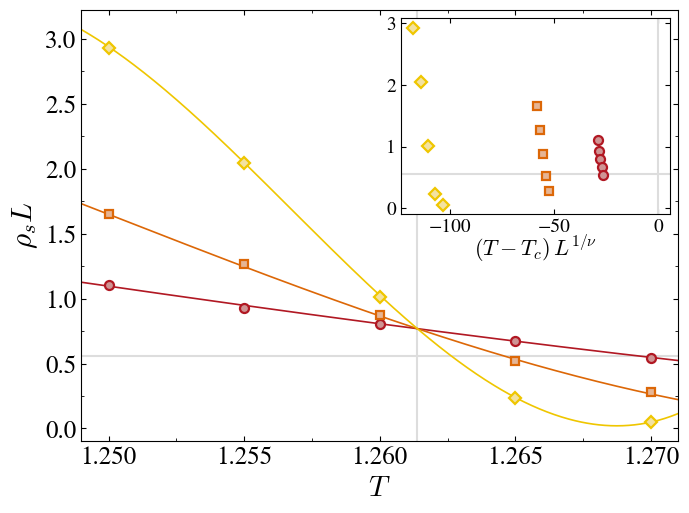

In [63]:
# main panel, crossings
var = fitFunction.unpack(params)
fig, ax0 = FS3.figure(xlabel=r'$T$', ylabel=r'$\rho_s L$')
xrange, yrange = FS3.getDataRange(data, idx=0, margin=0.05), FS3.getDataRange(data, idx=1, margin=0.05)
yrange[1] = 1.05*yrange[1]
ax0.set_xlim(xrange)
ax0.set_ylim(yrange)
FS3.setTicks(ax0, minorxTicks=2, minoryTicks=2)
plots = []
labels = []
for L in np.sort(list(data),axis=0):
    p = ax0.errorbar(data[L][:,0], data[L][:,1], yerr=data[L][:,2], **FS3.errorbarStyle(L), linestyle='')
    plots.append(p)
    labels.append(r'$L = %s$'%L)
    plotRange = FS3.getDataRange(data[L], idx=0, margin=0.05)
    g = np.linspace(plotRange[0], plotRange[1], 400)
    ax0.plot(g, fitFunction.func(g, L, params), **FS3.plotStyle(L))
FS3.legend(ax0, plots, labels, legendLabelBreak=7, loc=(0.74,0.72,0.18))
ax0.axhline(var['a'][0], color='#dddddd', zorder=-1000)
ax0.axvline(var['gc'], color='#dddddd', zorder=-1000)

# inset (data collapse)
fig, ax1 = FS3.addInset(fig, loc=3)
ax1.set_xlabel(r'$(T-T_c)\, L^{1/\nu}$')
dataCollapse = FS3.rescaleAxis(data, xfunc='(x-gc)*L**(1./nu) + c*L**(omega/nu)', yfunc='y', arg={'nu': var['nu'], 'gc': var['gc'], 'omega': var['omega'], 'c': var['c']})
for L in np.sort(list(data),axis=0):
    ax1.errorbar(dataCollapse[L][:,0], dataCollapse[L][:,1], yerr=dataCollapse[L][:,2], **FS3.errorbarStyle(L), linestyle='')
ax1.axhline(var['a'][0], color='#dddddd')
ax1.axvline(0, color='#dddddd')
#fig.savefig("spin_stiffness_s00_zoom.pdf")

# $\gamma$

<Axes: xlabel='$T$', ylabel='$\\chi$'>

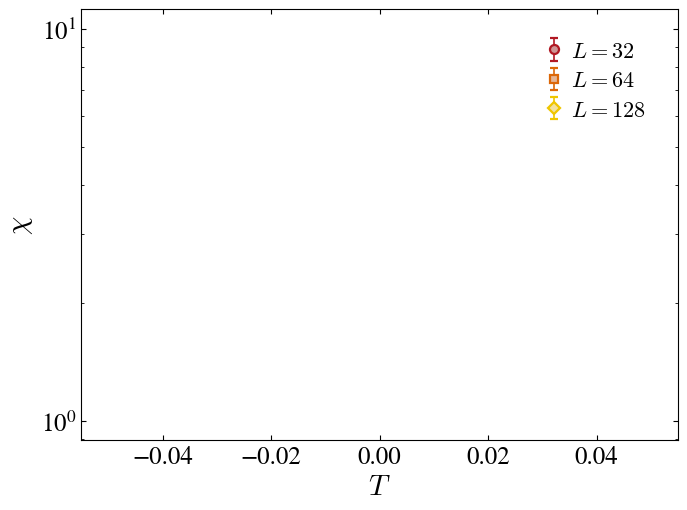

In [128]:
data = FS3.load('../data/susceptibilityLEO%s.dat'%(sigma), LIndex=0, xIndex=1, yIndex=2, dyIndex=3)
data = FS3.select(data, gRange=[1.3, 1.5])
FS3.setStyle(Llist=np.sort(list(data),axis=0))

fig, ax0 = FS3.figure(xlabel=r'$T$', ylabel=r'$\chi$')
ax0.set_yscale('log')
#ax0.set_xlim(0,)
#ax0.set_ylim(0,2)
#FS3.setTicks(ax0, minorxTicks=2, minoryTicks=2)
for L in np.sort(list(data.keys()), axis=0):
    ax0.errorbar(data[L][:,0], data[L][:,1], yerr=data[L][:,2], **FS3.errorbarStyle(L), linestyle='')
    ax0.plot(data[L][:,0], data[L][:,1], **FS3.plotStyle(L), linestyle='-')
FS3.legend(ax0, plots, labels, legendLabelBreak=7, loc=(0.74,0.72,0.18))


In [90]:
data = FS3.load(dir+'susceptibility.dat', LIndex=0, xIndex=1, yIndex=2, dyIndex=3)
data = FS3.select(data, gRange=[1.3, 1.5])
FS3.setStyle(Llist=np.sort(list(data),axis=0))

fig, ax0 = FS3.figure(xlabel=r'$T$', ylabel=r'$\chi$')
ax0.set_yscale('log')
#ax0.set_xlim(0,)
#ax0.set_ylim(0,2)
#FS3.setTicks(ax0, minorxTicks=2, minoryTicks=2)
for L in np.sort(list(data.keys()), axis=0):
    ax0.errorbar((data[L][:,0]-1.35)*L, data[L][:,1] * L**(-0.9), yerr=data[L][:,2], **FS3.errorbarStyle(L), linestyle='')
#    ax0.plot(data[L][:,0], data[L][:,1], **FS3.plotStyle(L), linestyle='-')
FS3.legend(ax0, plots, labels, legendLabelBreak=7, loc=(0.74,0.72,0.18))


TypeError: unsupported operand type(s) for +: 'builtin_function_or_method' and 'str'

In [173]:
class f0:
    def __init__(self):
        self.vars = ['gc', 'nu', 'gamma']   # define the variables used in your scaling function
        self.polyOrder = 0         # the polyomial expansion order in your scaling function

    def nparams(self):
        return len(self.vars) + np.sum(self.polyOrder) + 1
    
    def unpack(self, params):
        var = {}
        for name in list(self.vars):
            var[name] = params[self.vars.index(name)]
        var['a']  = params[len(self.vars):self.nparams() + 1]
        return var

    def func(self, g, L, params):
        var = self.unpack(params)
        nmax = len(var['a'])

        f = np.zeros_like(g)
        for n in range(nmax):
            f += var['a'][n] * ((g-var['gc']) * L**(1./var['nu']))**n
        f *= L**(-var['gamma']/var['nu'])
        return f

In [555]:
data = FS3.load(dir+'susceptibility.dat', LIndex=0, xIndex=1, yIndex=2, dyIndex=3)
data = FS3.select(data, gRange=[1.33, 1.35])
Llist = np.sort(list(data),axis=0)
FS3.setStyle(Llist=Llist)
for L in Llist:
    data[L][:,1:3] *= 1    # data = L*rho_s

g0 = 1.35
fitFunction = f0()
fitFunction.polyOrder = 3

params0 = np.hstack(([g0, 1.], np.random.randn(fitFunction.nparams()-2)))
res = FS3.fit_minimize(data, fitFunction, params=params0, **{'method': 'BFGS'})
params, dparams, redChi2, mesg, ierr = res

FS3.fitSummary(fitFunction, res)

IndexError: index 0 is out of bounds for axis 0 with size 0

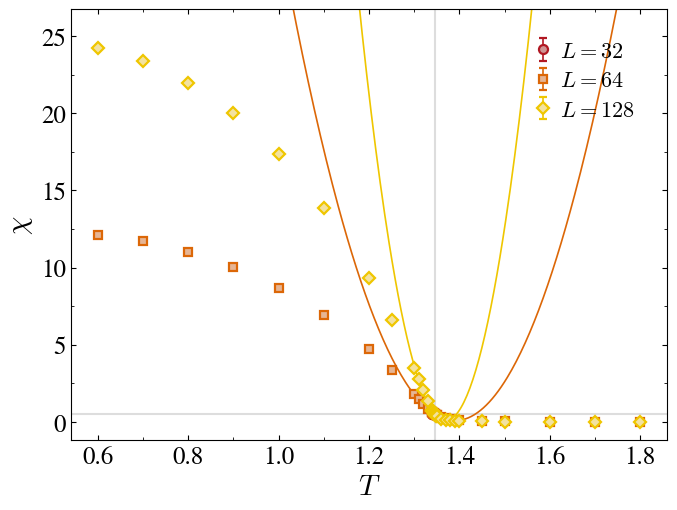

In [174]:
# main panel, crossings
var = fitFunction.unpack(params)
fig, ax0 = FS3.figure(xlabel=r'$T$', ylabel=r'$\chi$')
xrange, yrange = FS3.getDataRange(data, idx=0, margin=0.05), FS3.getDataRange(data, idx=1, margin=0.05)
yrange[1] = 1.05*yrange[1]
ax0.set_xlim(xrange)
ax0.set_ylim(yrange)
FS3.setTicks(ax0, minorxTicks=2, minoryTicks=2)
plots = []
labels = []
for L in np.sort(list(data),axis=0):
    p = ax0.errorbar(data[L][:,0], data[L][:,1], yerr=data[L][:,2], **FS3.errorbarStyle(L), linestyle='')
    plots.append(p)
    labels.append(r'$L = %s$'%L)
    plotRange = FS3.getDataRange(data[L], idx=0, margin=0.05)
    g = np.linspace(plotRange[0], plotRange[1], 400)
    ax0.plot(g, fitFunction.func(g, L, params), **FS3.plotStyle(L))
FS3.legend(ax0, plots, labels, legendLabelBreak=7, loc=(0.74,0.72,0.18))
ax0.axhline(var['a'][0], color='#dddddd', zorder=-1000)
ax0.axvline(var['gc'], color='#dddddd', zorder=-1000)

# inset (data collapse)
# fig, ax1 = FS3.addInset(fig, loc=3)
# ax1.set_xlabel(r'$(T-T_c)\, L^{1/\nu}$')
# ax1.set_ylabel(r'$\chi\, L^{-\gamma/\nu}$')
# dataCollapse = FS3.rescaleAxis(data, xfunc='(x-gc)*L**(1./nu)', yfunc='y*L**(-gamma/nu)', arg={'gamma': var['gamma'], 'nu': var['nu'], 'gc': var['gc']})
# for L in np.sort(list(data),axis=0):
#     ax1.errorbar(dataCollapse[L][:,0], dataCollapse[L][:,1], yerr=dataCollapse[L][:,2], **FS3.errorbarStyle(L), linestyle='')
# ax1.axhline(var['a'][0], color='#dddddd')
# ax1.axvline(0, color='#dddddd')

# $\eta$

In [34]:
#Tc= 2.43
Tc = 1.342
#Tc = 0.92
Tc = 0.64

Tc = 1.26

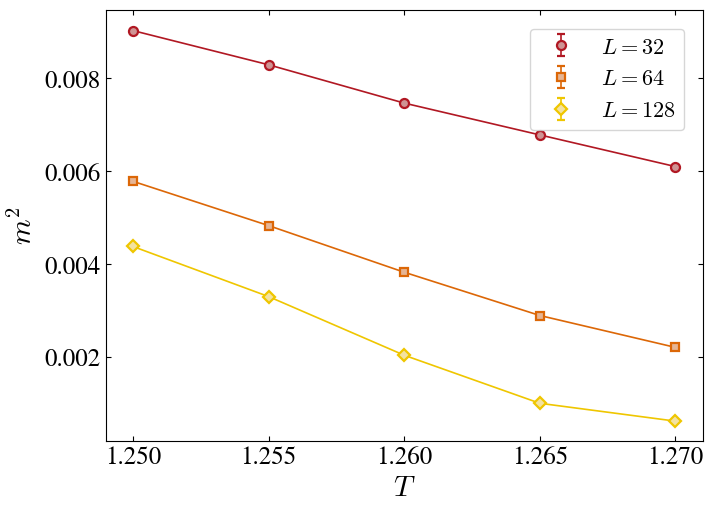

In [35]:
data = FS3.load('../dataJ/mag2%s.dat'%(sigma), LIndex=0, xIndex=1, yIndex=2, dyIndex=3)
FS3.setStyle(Llist=np.sort(list(data),axis=0))

fig, ax0 = FS3.figure(xlabel=r'$T$', ylabel=r'$m^2$')
#ax0.set_xlim(0,)
#ax0.set_ylim(0,2)
#FS3.setTicks(ax0, minorxTicks=2, minoryTicks=2)
for L in np.sort(list(data.keys()), axis=0):
    ax0.errorbar(data[L][:,0], data[L][:,1], yerr=data[L][:,2], **FS3.errorbarStyle(L), linestyle='', label=r'$L=%d$'%L)
    ax0.plot(data[L][:,0], data[L][:,1], **FS3.plotStyle(L), linestyle='-')
ax0.legend(loc=(0.71,0.72))
#fig.savefig("mag2_sm05.pdf")

In [36]:
def powerlaw(p, x):
    return p[0]*x**(-p[1])

def fit(x, y, xerr=0, yerr=0, p0=None):
    if type(xerr) == int: xerr = np.zeros_like(x)
    if type(yerr) == int: yerr = np.zeros_like(y)
    err_func = lambda p, x, y, xerr, yerr: (y - powerlaw(p,x)) / np.sqrt(xerr**2+yerr**2)
    
    if p0 == None: p0 = np.random.random(2)
    mean, cov, info, mesg, ierr = sp.optimize.leastsq(err_func, p0, args=(x,y,xerr,yerr), full_output=1)
    rchi2 = np.sum(err_func(mean, x, y, xerr, yerr)**2)/(len(x)-len(mean))

    return mean, np.sqrt(rchi2*np.diag(cov)), rchi2

Tc = 1.260000
@ T = 1.260000
eta = 0.94(2)


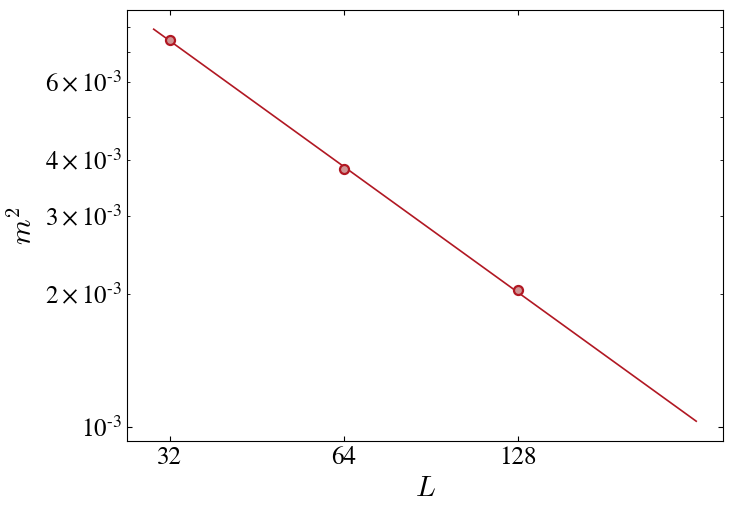

In [38]:
data = FS3.load('../dataJ/mag2%s.dat'%(sigma), LIndex=0, xIndex=1, yIndex=2, dyIndex=3)
Llist = np.sort(list(data),axis=0)
FS3.setStyle(Llist=Llist)

tab = np.empty((0,3))
for L in np.sort(list(data.keys()), axis=0):
    imin = np.argmin(np.abs(data[L][:,0]-Tc))
    tab = np.vstack((tab, np.array([L, data[L][imin,1], data[L][imin,2]])))
print('Tc = %f'%(Tc))
print('@ T = %f'%(data[L][imin,0]))

fig, ax0 = FS3.figure(xlabel=r'$L$', ylabel=r'$m^2$')
ax0.errorbar(tab[:,0], tab[:,1], yerr=tab[:,2], **FS3.errorbarStyle(32), linestyle='')
ax0.set_xscale('log')
ax0.set_yscale('log')
#ax0.set_xticks(Llist)
FS3.setTicks(ax0, xTicks=Llist)
for axis in [ax0.xaxis]:
    axis.set_major_formatter(mpl.ticker.ScalarFormatter())
    axis.set_minor_formatter(mpl.ticker.NullFormatter())
ax0.xaxis.set_minor_locator(mpl.ticker.NullLocator())

mean, err, rchi2 = fit(tab[:,0], tab[:,1], yerr=tab[:,2], p0=[0.1, 0.7])
x = np.linspace(30,260,1000)
ax0.plot(x, powerlaw(mean, x), '-', **FS3.plotStyle(32))
print('eta = %s'%(FS3.errText(mean[1],err[1])))
#fig.savefig("mag2_L_sm05.pdf")

In [39]:
# Scaling function

class Rg0:
    def __init__(self):
        self.vars = ['eta']        # define the variables used in your scaling function
        self.polyOrder = 0         # the polyomial expansion order in your scaling function

    def nparams(self):
        return len(self.vars) + np.sum(self.polyOrder) + 1
    
    def unpack(self, params):
        var = {}
        for name in list(self.vars):
            var[name] = params[self.vars.index(name)]
        var['a']  = params[len(self.vars):self.nparams() + 1]
        return var

    def func(self, g, L, params):
        var = self.unpack(params)
        nmax = len(var['a'])

        f = np.zeros_like(g)
        for n in np.arange(nmax):
            f += var['a'][n] * g**n
        f = L**(-var['eta']) * f
        return f

$L^{1-\eta}f(L)$ = $L^{2\beta/\nu}f(L)$ 

In [40]:
dataR = FS3.load('../dataJ/Binder%s.dat'%(sigma), LIndex=0, xIndex=1, yIndex=2, dyIndex=3)
dataM = FS3.load('../dataJ/mag2%s.dat'%(sigma), LIndex=0, xIndex=1, yIndex=2, dyIndex=3)
dataR = FS3.select(dataR, gRange=Trange)
dataM = FS3.select(dataM, gRange=Trange)
Llist = np.sort(list(dataR),axis=0)

data = {}
for L in Llist:
    Tlist = dataR[L][:,0]
    data[L] = np.empty((0,4))
    for T in Tlist:
        iR = np.argwhere(dataR[L][:,0] == T)[0,0]
        iM = np.argwhere(dataM[L][:,0] == T)[0,0]
        data[L] = np.vstack((data[L], np.array([dataR[L][iR,1], dataR[L][iR,2], dataM[L][iM,1], dataM[L][iM,2]])))

In [43]:
fitFunction = Rg0()
fitFunction.polyOrder = 3

params0 = np.zeros(fitFunction.polyOrder+1)
params0[0] = 0.982
params0[1:] = np.random.randn(fitFunction.polyOrder)
res = FS3.fit_minimize(data, fitFunction, params=params0, **{'method': 'BFGS'})
params, dparams, redChi2, mesg, ierr = res

FS3.fitSummary(fitFunction, res)
print(params)

chi2/d.o.f = 0.01          
eta = 0.9(3)
a[0] = 0.0(2)
a[1] = 0.0(7)
a[2] = 0.2(9)

[0.89400355 0.04697379 0.04141401 0.24571048]


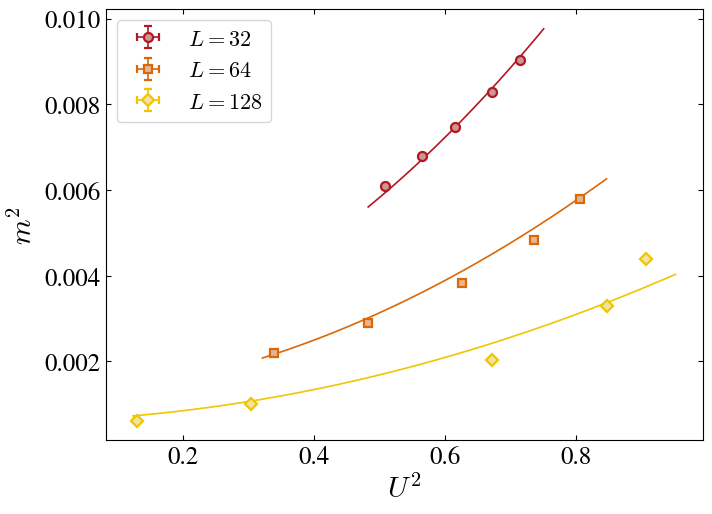

In [44]:
FS3.setStyle(Llist=Llist)
fig, ax0 = FS3.figure(xlabel=r'$U^2$', ylabel=r'$m^2$')
for L in Llist:
    ax0.errorbar(data[L][:,0], data[L][:,2], xerr=data[L][:,1], yerr=data[L][:,3], **FS3.errorbarStyle(L), linestyle='', label=r'$L = %d$'%L)
    g = np.linspace(FS3.getDataRange(data[L])[0] * 0.95, FS3.getDataRange(data[L])[1] * 1.05, 1000)
    ax0.plot(g, fitFunction.func(g, L, params), **FS3.plotStyle(L))
ax0.legend()

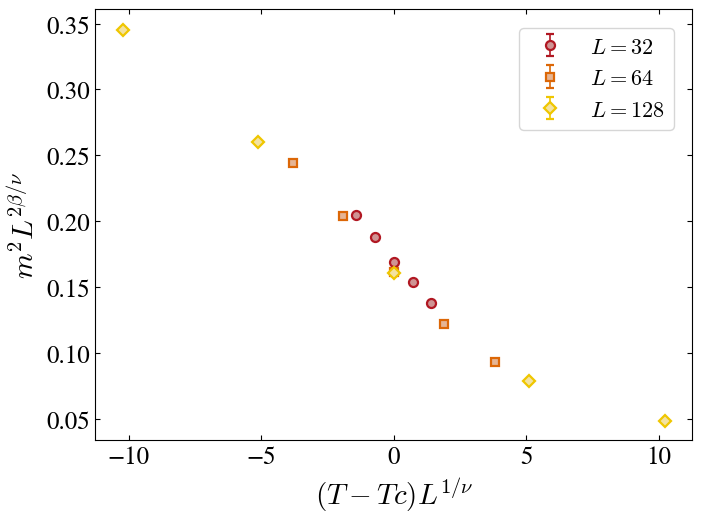

In [50]:
eta = fitFunction.unpack(params)['eta']
eta = 0.9
Tc = 1.26
nu = 0.7

omega = -1000
c = 277

data = FS3.load('../dataJ/mag2%s.dat'%(sigma), LIndex=0, xIndex=1, yIndex=2, dyIndex=3)
FS3.setStyle(Llist=np.sort(list(data),axis=0))

fig, ax0 = FS3.figure(xlabel=r'$(T-Tc) L^{1/\nu}$', ylabel=r'$m^2 L^{2\beta/\nu}$')
#ax0.set_xlim(-9,5.5)
#ax0.set_ylim(0.,1)
#FS3.setTicks(ax0, minorxTicks=2, minoryTicks=2)
for L in np.sort(list(data.keys()), axis=0):
    ax0.errorbar((data[L][:,0]-Tc)*L**(1/nu) + c*L**(omega/nu), data[L][:,1]*L**eta, yerr=data[L][:,2]*L**eta, **FS3.errorbarStyle(L), linestyle='', label=r'$L=%d$'%L)
ax0.legend(loc=(0.71,0.72))
fig.savefig("Data_collapse_sm05.pdf")

In [528]:
nupMe = np.array([
    [1.5, 0.97, 0.07],
    [2.0, 1.01, 0.05],
    [2.5, 1.17, 0.07],
    [3.0, 2.70, 0.05]
])
etaMe = np.array([
    [1.5, 0.982, 0.02],
    [2.0, 0.9, 0.03],
    [2.5, 0.625, 0.02],
    [3.0, 0.28, 0.03]
])

# Data Zhao23

In [476]:
nupZhao23 = np.array([# alpha, mean, err
[2.30, 1.02932108, 0.03546215],
[2.50, 1.02949726, 0.03533631],
[2.70, 1.00060404, 0.03493362],
[2.90, 0.99131693, 0.03495879],
[3.00, 1.00113257, 0.03168691],
[3.05, 1.01031901, 0.03488328],
[3.10, 1.02081419, 0.03128421],
[3.15, 1.03100736, 0.03115837],
[3.20, 1.03445542, 0.03113320],
[3.30, 1.09020323, 0.03855786],
[3.40, 1.11079091, 0.07364248],
[3.50, 1.27936828, 0.07973322],
[3.60, 1.49898698, 0.11839174],
[3.70, 1.63819292, 0.12581640]])

betaZhao23 = np.array([# alpha, mean, err
[2.30, 0.52924515, 0.03442599],
[2.50, 0.53276764, 0.03373602],
[2.70, 0.52270857, 0.03476493],
[2.90, 0.48908149, 0.03500702],
[3.00, 0.50858229, 0.03129085],
[3.05, 0.49458916, 0.03475282],
[3.10, 0.44402750, 0.03113349],
[3.15, 0.43905244, 0.03141190],
[3.20, 0.39971191, 0.03112139],
[3.30, 0.39729095, 0.03809374],
[3.40, 0.31500266, 0.04201569],
[3.50, 0.31367114, 0.04538082],
[3.60, 0.31471215, 0.05574251],
[3.70, 0.31986878, 0.06959037]])

etaZhao23 = np.array([# alpha, mean, err
[2.30, 1.00482525, 0.02614361],
[2.50, 1.00591571, 0.02854261],
[2.70, 1.00635189, 0.01927376],
[2.90, 0.99920942, 0.02554386],
[3.00, 1.01951911, 0.02306308],
[3.05, 0.96927648, 0.02189085],
[3.10, 0.92233248, 0.02276321],
[3.15, 0.88670192, 0.01019574],
[3.20, 0.79055122, 0.02090944],
[3.30, 0.71830871, 0.02041873],
[3.40, 0.61425222, 0.02088218],
[3.50, 0.49795540, 0.01984625],
[3.60, 0.41900660, 0.02000981],
[3.70, 0.38471185, 0.02219072]])

TcZhao23 = np.array([# alpha, mean, err
[2.30, 5.68075223, 0.06713568],
[2.50, 3.57807943, 0.03346261],
[2.70, 2.60208653, 0.02104567],
[2.90, 2.02985478, 0.02104567],
[3.00, 1.82160789, 0.02083521],
[3.05, 1.72427167, 0.02104567],
[3.10, 1.64471904, 0.02104567],
[3.15, 1.55590632, 0.02104567],
[3.20, 1.48677129, 0.00947055],
[3.30, 1.34808033, 0.00947055],
[3.40, 1.23264484, 0.00926009],
[3.50, 1.12815309, 0.00947055],
[3.60, 1.01587445, 0.00926009],
[3.70, 0.93021857, 0.00926009]])



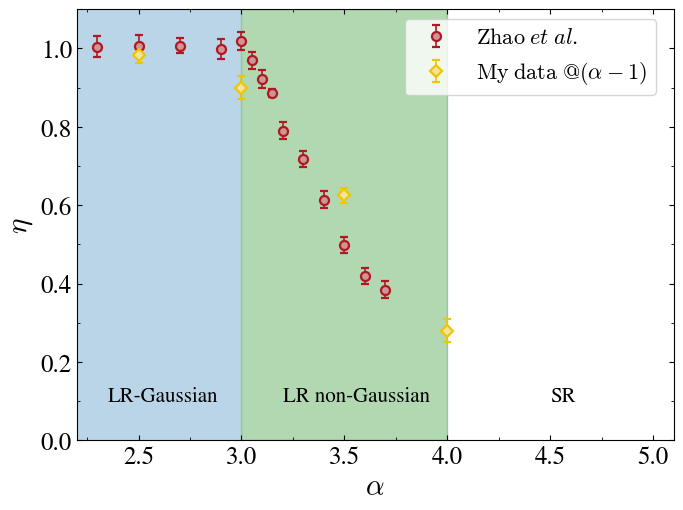

In [525]:
from matplotlib.patches import Rectangle
fig, ax0 = FS3.figure(xlabel=r'$\alpha$', ylabel=r'$\eta$')
ax0.set_xlim(2.2, 5.1)
ax0.set_ylim(0.,1.1)
FS3.setTicks(ax0, minorxTicks=2, minoryTicks=2)
ax0.errorbar(etaZhao23[:,0], etaZhao23[:,1], yerr=etaZhao23[:,2], **FS3.errorbarStyle(32), linestyle='', label=r'${\rm Zhao}\;{\it et\; al.}$')
ax0.errorbar(etaMe[:,0]+1, etaMe[:,1], yerr=etaMe[:,2], **FS3.errorbarStyle(128), linestyle='', label=r'${\rm My}\;{\rm data}\;@ (\alpha - 1)$')
ax0.add_patch(Rectangle((0,0),3,1.1, alpha = 0.3))
ax0.add_patch(Rectangle((3,0),1,1.1, alpha = 0.3,color = "green"))
ax0.text(2.35,0.1,"LR-Gaussian",fontsize="15")
ax0.text(3.2,0.1,"LR non-Gaussian",fontsize="15")
ax0.text(4.5,0.1,"SR",fontsize="15")
#ax0.plot([0,3], [1, 1], '--', color='#dddddd', zorder=-100)
#ax0.plot([3.9,5.1], [0.035, 0.035], '--', color='#dddddd', zorder=-100)
#ax0.plot([3,4], [1, 0], '--', color='#dddddd', zorder=-100)
ax0.legend(loc=(0.55,0.8))
fig.savefig("eta_Zhao.pdf")

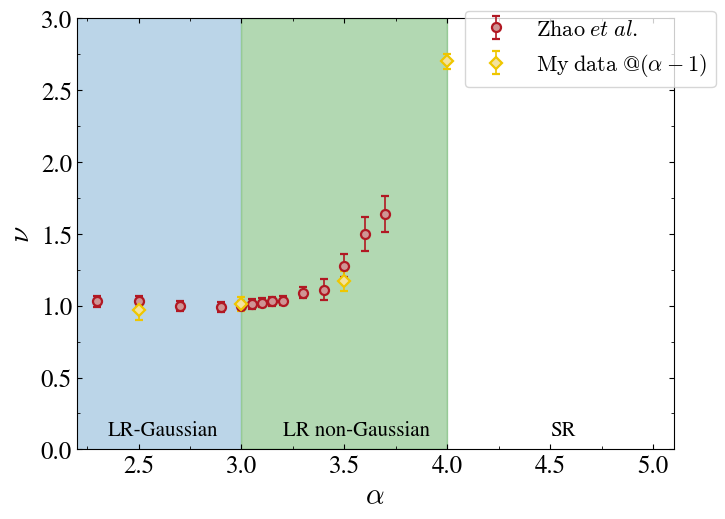

In [533]:
fig, ax0 = FS3.figure(xlabel=r'$\alpha$', ylabel=r'$\nu$')
ax0.set_xlim(2.2, 5.1)
ax0.set_ylim(0.,3.0)
FS3.setTicks(ax0, minorxTicks=2, minoryTicks=2)
ax0.errorbar(nupZhao23[:,0], nupZhao23[:,1], yerr=nupZhao23[:,2], **FS3.errorbarStyle(32), linestyle='', label=r'${\rm Zhao}\;{\it et\; al.}$')
ax0.errorbar(nupMe[:,0]+1, nupMe[:,1], yerr=nupMe[:,2], **FS3.errorbarStyle(128), linestyle='', label=r'${\rm My}\;{\rm data}\;@ (\alpha - 1)$')
d = 2
a = np.linspace(3,6,1000)
# D = 2
#ax0.plot(a, 0.707*(a-d)*(3/2)/d, '--', color='#dddddd', zorder=-100)
#ax0.plot([0,3], [1, 1], '--', color='#dddddd', zorder=-100)
#ax0.plot([3.9,5.1], [0.707, 0.707], '--', color='#dddddd', zorder=-100)
ax0.add_patch(Rectangle((0,0),3,3, alpha = 0.3))
ax0.add_patch(Rectangle((3,0),1,3, alpha = 0.3,color = "green"))
ax0.text(2.35,0.1,"LR-Gaussian",fontsize="15")
ax0.text(3.2,0.1,"LR non-Gaussian",fontsize="15")
ax0.text(4.5,0.1,"SR",fontsize="15")

ax0.legend(loc=(0.65,0.84))
fig.savefig("nu_Zhao.pdf")

(0.0, 1.575)

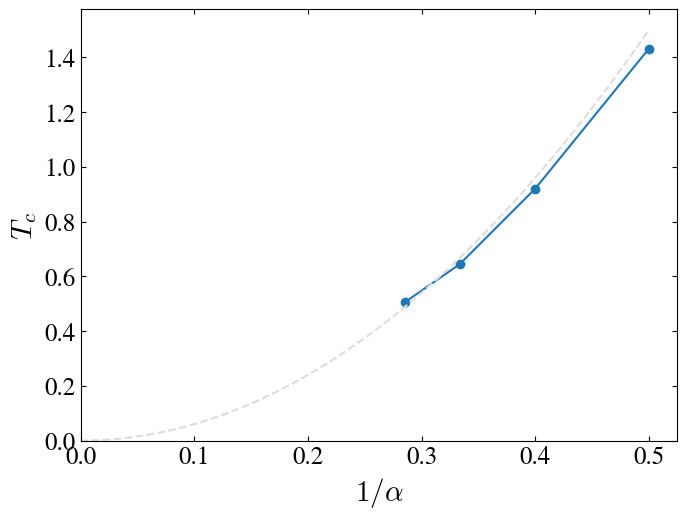

In [1473]:
Tc = np.array([
[2.0, 1.432],
[2.5, 0.92039],
[3.0, 0.64367],
[3.5, 0.5067]])

fig, ax0 = FS3.figure(xlabel=r'$1/\alpha$', ylabel=r'$T_c$')
ax0.plot(1/Tc[:,0],Tc[:,1], 'o-')
x = np.linspace(0,0.5,1000)
ax0.plot(x,6*x**2, '--', color='#dddddd')
ax0.set_xlim(0,)
ax0.set_ylim(0,)

(0.0, 1.65)

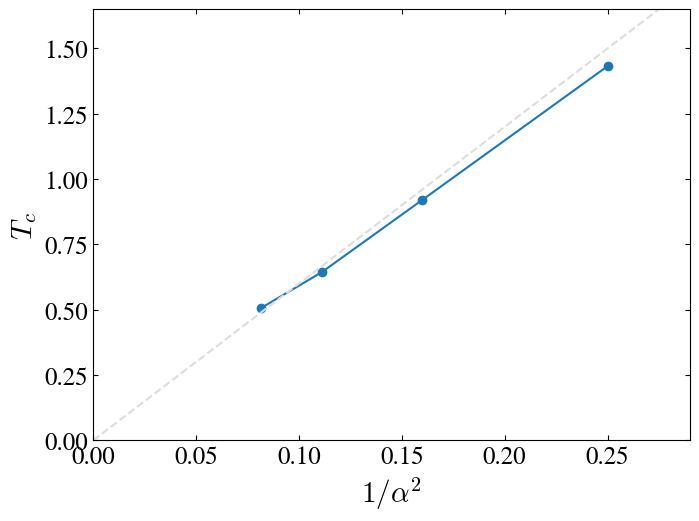

In [1459]:
Tc = np.array([
[2.0, 1.432],
[2.5, 0.92039],
[3.0, 0.64367],
[3.5, 0.5067]])

fig, ax0 = FS3.figure(xlabel=r'$1/\alpha^2$', ylabel=r'$T_c$')
ax0.plot(1/Tc[:,0]**2,Tc[:,1], 'o-')
x = np.linspace(0,0.5,1000)
ax0.plot(x,6*x, '--', color='#dddddd')
ax0.set_xlim(0,0.29)
ax0.set_ylim(0,1.65)